# Neural Networks for Data Science Applications
## Homework 1: Saliency maps for interpretability

**Name**: *Giuseppe Di Poce*

**Matricola**: *2071371*

> ✍ Upload the completed notebook **before 17/11/2023 at 23:59** on the Google Classroom page.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import glorot_normal
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Overview

Neural networks are powerful tools, but they are **black-boxes**, meaning that it is difficult to provide human-understandable explanations on what they are doing. The field of **explanaibility** is concerned with finding algorithms for achieving this. In this homework, you will be guided in implementing some basic explanaibility algorithms (**saliency maps**), which is an instructive way of playing with the TensorFlow autodiff framework.

### Instructions

1. The homework is divided into four mandatory exercises (**5 points in total**), and a few optional exercises. Optional exercises are provided if you like the topic and would like to explore more; you are free to ignore them or complete as many as you want. I will not grade them but I might provide feedback for especially nice solutions.
2. Completing the homework successfully will remove 1 exercise from the end-of-term homework.
3. If your grade does not satisfy you, you are also free to complete the full EoT homework to recover it.
3. The grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

## Warmup: Data loading

For this homework, you can select any **tabular dataset** that you like, for either classification or regression. A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. The choice of dataset will not influence the mark.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

##Diagnostic Wisconsin Breast Cancer Database
![Tumor cell](https://storage.googleapis.com/kaggle-datasets-images/3032092/5212576/69196f95972506ae66da827386432a26/dataset-cover.jpg?t=2023-03-23-10-05-44)\
The data taken into consideration for the task assigned in this homework essentially concerning the detection of malignant or benign breast cancer cells and are in tabular form (569 instances and 30 features).\
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image that are in the below form:

![FNA images](https://www.researchgate.net/profile/Glaucia-Sizilio/publication/232811011/figure/fig3/AS:214220353347586@1428085520095/Captured-images-of-layers-of-glass-with-smears-of-breast-mass-obtained-by-FNA-the-parts.png)\
Basically we have features like *worst values*, *standard error* or *mean* coming from ***compactness, concavity, area, texture*** and other characteristics of breast cell nuclei. In particular standard error in the case provides information about the variability or uncertainty associated with those measurements.
For example, in "compactness_se" and "radius_se." these represent the standard error of the compactness and radius measurements, respectively. The "se" values gives an idea of how much individual measurements of compactness or radius might vary around their mean values within a specific section of the tumor.





From the photo above we can distinguish a different density of cells in the two classification states (benign or malignant). Infact reast density is an intrinsic risk factor for breast cancer and increases the risk 4 to 6 times. Furthermore, breast density can mask the presence of a lump, especially if it is still very small.
Others images can be found at http://www.cs.wisc.edu/~street/images/ \
The feature extraction from images to create this dataset is very interesting and can be found [here](https://www.semanticscholar.org/paper/Nuclear-feature-extraction-for-breast-tumor-Street-Wolberg/53f0fbb425bc14468eb3bf96b2e1d41ba8087f36). Basically data may be considered linearly separable also in a $R^{30}$ space on which our data points lie.\
Let's import our breast cancer data directly from Kaggle and have a look to them.



In [ ]:
!pip install kaggle
from google.colab import files
files.upload()  # The bottom 'Choose file' below this cell request your Kaggle.json file that you can download form Kaggle settings in your profile;

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"giuseppedipoce","key":"d587733de92c6b896021479adda0fa49"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d erdemtaha/cancer-data
!unzip cancer-data.zip

  0% 0.00/48.6k [00:00<?, ?B/s]
100% 48.6k/48.6k [00:00<00:00, 86.9MB/s]
Archive:  cancer-data.zip
  inflating: Cancer_Data.csv         


In [ ]:
"https://www.kaggle.com/datasets/erdemtaha/cancer-data/data" #URL of Kaggle
data= pd.read_csv("Cancer_Data.csv")
id = data.id #id column that we can set as index to have each row informative to the patitent id given
data= data.drop("Unnamed: 32",axis=1) #there is a NaN column (probably a mistake in the upload of data on Kaggle)
data['diagnosis']=np.where(data['diagnosis']=='M',1,0) #encode the target variable: 1=Malignant, 0= benignant
data.set_index('id', inplace=True)
data.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Now, going step by step, we need:

- As first, before going deep in Deep Learning filed, we need to *standardize* the data in order to avoid gradient issues: having features on vastly different scales can lead to gradient-related problems during training, such as vanishing or exploding gradients. Standardizing the data can mitigate these issues and improve generalization performance by preventing certain features from dominating the learning process, simply because they have larger scales;

- Since we have in the data first observations belonging to one target (malignant) and then to the other, we will have to perform a shuffle on the rows to enable the model during trainning to see observations belonging to different classes in a more varied manner .

In [ ]:
#Standardize data:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(data.drop("diagnosis", axis=1)))
X.set_index(id, inplace=True)
y = data.diagnosis
X.columns = data.drop("diagnosis", axis=1).columns
#So now we have our standardized input data in X and target in y.

In [ ]:
#Split in train and test
test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state=42)
# Convert to TensorFlow Dataset
data_train = tf.data.Dataset.from_tensor_slices((X_train.values,y_train.values))
data_test = tf.data.Dataset.from_tensor_slices((X_test.values,y_test.values))
# Shuffle the dataset: train a model with as first all the observation belonging to a target variable and later the other one
#is not desirable, so we have to shuffle the rows of the dataset with a tensorflow method:
buffersize = len(X_train)
data_train = data_train.shuffle(buffer_size=buffersize)
data_test = data_test.shuffle(buffer_size=buffersize) #notice that this will return a tensorflow._ShuffleDataset object

### Exercise 1: Train a neural network model (1 point)

Define, train, and test a neural network for the provided dataset.

☝ You are free to make any modelling choice (e.g., activation function, normalization layers, etc.), provided the result makes sense.

✅ **Completion requirement**: print on screen the test accuracy of the network. Additional comments and visualizations are also appreciated.

In [ ]:
#TODO: define an architecture and train the model.

#Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Input layer
    tf.keras.layers.Dense(32, activation='relu', kernel_initializer='glorot_normal'),#Due to the fact that data are linearly separable a linear choice for act. function  here will be fine too
                                                                                     #but we choose a ReLu because if we keep a linear one all the w will be the same, constant, and
                                                                                     #this is not desirable for our explainability task.
    tf.keras.layers.Dense(16, activation='relu', kernel_initializer='glorot_normal'),  #Hidden layer 2
    tf.keras.layers.Dense(1, activation=None)  # Output layer for binary classification, as in [1] we
                                                #are interested in using un-normalized scores (logit) so we
                                                #do not apply a output function (like softmax/sigmoid) to convert logits in probabilities.
                                                #in the loss function definition we will call the from_logits=True parameter.
])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),#Logits are unnormalized output values produced
                                                                        #by the last layer (Sc score refferring to [1] in references)
              metrics=['accuracy'])                                     # if we print at screen the values of a model.predict(X_test), the values will be real numbers and not
                                                                        #probabilities among [0,1], and this is due to the logit=True parameter.

#-------------------------------------------------------------------------------
# Train the model
batch_size = 32
epochs = 100
# Calculate the number of validation samples
validation_samples = int(0.25 * len(X_train))
# Create training and validation datasets
train_dataset = data_train.skip(validation_samples).batch(batch_size) #exclude the first validation 'segment' from the training data
validation_dataset = data_train.take(validation_samples).batch(batch_size) #create a validation dataset containing only the first validation elements.

training = model.fit(data_train.batch(batch_size), epochs=epochs,verbose=False, callbacks=[early_stopping], validation_data=validation_dataset )
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                992       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# TODO: test the neural network and print the result on screen.
L, test_accuracy = model.evaluate(X_test,y_test, verbose=0)
print(f'Accuracy on test set:',round(test_accuracy,3))

Accuracy on test set: 0.974


### Exercise 2: Computing a vanilla saliency map (1 points)

> Before starting, I suggest you read [1] as a warm-up. This is one of the first papers that tried to apply this kind of techniques to modern neural networks.

What do we mean by explainability? Consider the neural network $f(\cdot)$ you just trained, and a prediction $\hat{y} = f(x)$ we want to analyze. **Feature attribution** methods try to assign a weight $w_i$ to each input feature $x_i$, to understand which parts of the input have contributed the most to the explanation.

The simplest feature attribution technique, called **vanilla saliency map**, simply computes the gradient at that point:

$$
  S(x) = \left\lvert \frac{\partial f_c(x)}{\partial x} \right\rvert
$$

where  $c$ is the index corresponding to the predicted class.

✅ **Completion requirement**: Take any point from your test dataset, and compute a saliency map using `tf.GradientTape`. Check the weight to see if you can find anything to "interpret". **Note**: I am not evaluating how nice / good the explanation is, only the code.

In [ ]:
#TODO: Take an element from your test set and compute the saliency map
#Notiche that we build this function to pass the entire dataset to it,
#so in request 4.1 the function to be used will still be the same this function!

def Vanilla_Silency_grad(X_input,model):
  inputs= tf.convert_to_tensor(X_input, dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(inputs)
    logits = model(inputs) #forward pass

  # Get the gradients of the logits with respect to the input
  #basically we start the backpropagation step from the unormalized logits instead that from output probabilities
  gradients = tf.abs(tape.gradient(logits, inputs)) #backward pass
                                                    #there's no need to use tf.vectorized_map() in this specific case to vectorize the gradient operations (as requested)
                                                    #TensorFlow oalready allows for efficient parallelization across the entire batch, and there's no need for additional element-wise mapping in this case.
                                                    #Apply min-max normalization to each vector in gradients, explanation of this below
  min_vals = tf.reduce_min(gradients, axis=1, keepdims=True)
  max_vals = tf.reduce_max(gradients, axis=1, keepdims=True)
  n_gradients = (gradients - min_vals) / (max_vals - min_vals)
  return(n_gradients)

gradients = Vanilla_Silency_grad(X_test,model)
# Get the gradients for the first datapoint and display it
gradients[0]

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([0.28237873, 0.8480236 , 0.05680618, 0.4204312 , 0.09587716,
       0.22032171, 0.29815072, 0.07823738, 0.02057443, 0.03300347,
       0.7345864 , 0.        , 0.25065336, 0.6968416 , 0.03564823,
       0.7289195 , 0.2627937 , 0.02191735, 0.2773445 , 0.33892167,
       0.9619572 , 0.880362  , 0.17022708, 1.        , 0.06195559,
       0.51276153, 0.80439156, 0.32269868, 0.6352545 , 0.26868176],
      dtype=float32)>

- *Min- Max* scaler on $∇_{input} logit$:\
Please notice that the output 'gradients' object it's been normalized s.t. each $\omega_i \in (0,1)$ with a *min-max* scaler.\
We make this choice in order to make easier to compare the weighting of different features and have better visualization of the silency map (of a single data point and  mainly for the silency of the total dataset).\
In this way we ensure that the importance assigned to different features is consistent and not biased by the absolute scale of the gradients.
Normalization makes the saliency maps more robust to changes in the scale of gradients and helps to prevent situations where small changes in the model or input data lead to significant changes in the saliency map, making the interpretation more stable. This is also a way to affect less the silency map wrt the activation function choices made in the model.

The key idea towards which we row is that the gradients of the $i^{th}$ input computed with respect to the $i^{th}$ logits
(unnormalized scors $S_c$) may be considered a measure of importance, a score in turn expressing the importance of that specific feature for that specific data point and how much it affects the output;\
Please notice that in the $[1]$ the weights are defined as
 $$\omega_c =\left.\frac{\partial S_c}{\partial x}\right|_{x^{i}}$$
whith the $ S_c(x^{i})=\omega_c^T x^{i}+b_c$. So $[1]$ take into account the different $c$ classes which the data point belongs to when computing the score. In this task by the way it's not specified whether the score should take into account the different membership classes or not, so for simplicity's sake we will calculate the silency map of the $i^{th}$ observation without taking the membership class into account, and later in this notebook we will compare them according to $c$ in a global view, not just onto a sigle data point. Notice that the class do not affect the magnitudes of the silency map but a visualization divided by the target labels may be more explicative, especially in a global view of many data points.



In [ ]:
#TODO: We need to figure out a silency map from our gradients
#-------------------------------------------------------------------------------
gradients_np = gradients.numpy()
# Create a pandas DataFrame from the NumPy array
silency_df = pd.DataFrame(gradients_np)
silency_df.columns, silency_df.index = X_test.columns, X_test.index
silency_map = silency_df.iloc[:1,:].T.style.background_gradient(cmap='binary', vmin=silency_df.iloc[0, :].mean(), vmax=silency_df.iloc[0, :].max())
silency_map #let's dispaly the silency map with values of bigger magnitudes representing most influent features wrt output

id,87930
radius_mean,0.282379
texture_mean,0.848024
perimeter_mean,0.056806
area_mean,0.420431
smoothness_mean,0.095877
compactness_mean,0.220322
concavity_mean,0.298151
concave points_mean,0.078237
symmetry_mean,0.020574
fractal_dimension_mean,0.033003


In [ ]:
# TODO: Check the saliency map to analyze the result. What can you say about the map?
patient = silency_df.iloc[:1,:] #first patient weighting features coefficients
patient.loc[:,patient.iloc[0] >0.75] #setting arbitrarly a threshold on the magnitude of 0.6 we can state that the most influet features on the output are the one shown below
#but please be aware that this silency don't distinguish by class c

,texture_mean,radius_worst,texture_worst,area_worst,concavity_worst
id,,,,,
87930,0.848024,0.961957,0.880362,1.0,0.804392


We can observe that the "area" feature seems to be informative wrt output, also "radius" standard error and "texture_worst" feature results to be the features with $\omega$ greater magnitude.

From a more general point of view, it appears from this vector map, that the average values ("mean" features) seems to be not much informative as they have $\omega$ with low values. On the other hand, standard error and especially worst values of specific features (like texture) seem to be more influential wrt the output, because they have a greater multiplicity of values with higher magnitude.


### Exercise 3: Advanced saliency maps (1 point)

> For this exercise, you can read [2] for an overview on the limits of vanilla saliency maps and a description of SmoothGrad.

Saliency maps have several issues: most notably, they suffer from noise and they are not stable to small changes in the input or in the model (try running again the training and interpreting the same point). Many methods have been proposed to overcome this.

**[SmoothGrad](https://arxiv.org/abs/1706.03825)**, for example, computes multiple saliency maps from noisy versions of the input:

$$
  \text{SmoothGrad}(x) = \frac{1}{n}\sum_{i=1}^n S(x + \varepsilon_i), \;\; \varepsilon_i \sim \mathcal{N}(0, \sigma^2I)
$$

where $\varepsilon$ is a vector of the same shape as $x$, whose values are sampled from a normal distribution with zero mean and small variance.

🟩 **Completion requirement**: Implement the SmoothGrad procedure for the same point. Has the explanation improved? Bonus points if you can avoid running a for-loop, and by calling the gradient operation a single time.


In [ ]:
# TODO: Take an element from your test set and compute SmoothGrad. Check the results and compare with respect to the previous exercise.

#We define the noise_level as : {sd /(tf.reduce_max(x_i)-tf.reduce_min(x_i))} like carry out in [2] reference.
#We wil also check the differences adding noises and if a range of 10%-20% is truly better, also in tabular data case.
#-------------------------------------------------------------------------------
# Define a function that computes the SmoothGrad procedure
def SmoothGrad(input_, sd, n=10**6):
    # Generate normal random noise as explained in the [2] reference.
    noise_segment = tf.random.normal(shape=tf.shape(input_), mean=0, stddev=sd, dtype=tf.float32)

    # Repeat x_i n_samples times avoiding for loops
    x_i_samples = tf.tile(input_, [n, 1])

    # Add noise to the input samples
    noise_samples = tf.cast(x_i_samples, dtype=tf.float32) + noise_segment # each replicated instance of x_i inside x_i_samples will have independent noise added to it.
                                                                   # This ensures that each of the replicated samples has a slightly different input due to the added noise
    with tf.GradientTape() as tape:
        tape.watch(noise_samples)  # gradient wrt x_i_samples
        logits = model(noise_samples)  # forward pass

    # Get the gradients of the logits with respect to the input
    M_c_samples = tf.abs(tape.gradient(logits, noise_samples))
    min_val = tf.reduce_min(M_c_samples, axis=1, keepdims=True)
    max_val = tf.reduce_max(M_c_samples, axis=1, keepdims=True)
    n_M_c = (M_c_samples - min_val) / (max_val - min_val)

    #Average the gradients over the samples
    avg_gradients = tf.reduce_mean(n_M_c, axis=0)
    avg_gradients = tf.reshape( avg_gradients, (1, 30))

    return avg_gradients
#-------------------------------------------------------------------------------
#Define a function to display the result tensor in dataframe form to be able to generate the silency map style.
def show_grad(smoothgrad_results,X_test):
  smoothgrad_result_np = smoothgrad_results.numpy()
  # Create a pandas DataFrame from the NumPy array
  smoothgrad_df = pd.DataFrame(smoothgrad_result_np)
  smoothgrad_df.columns = X_test.columns
  idx = id[0]#save the index of the patient with we are dealing with
  smoothgrad_df.rename(index={0: idx}, inplace=True) #and reset the original patient index
  return(smoothgrad_df)


In [ ]:
#take the first patient of the test set as observation:
x_i = X_test.iloc[:1,:]

#percentage of noise has been defined like this:
# sd = #pick the value that you need of stand. dev.
# perc_noise = (sd/(x_i.max(axis=1)- x_i.min(axis=1)))*100

#compute the SmoothGrad procedure as defined above adding different levels of nopise: we are trying to replicate [2]
SG_5_noise = show_grad(SmoothGrad(x_i,sd=0.05), X_test)
SG_10_noise = show_grad(SmoothGrad(x_i,sd=0.010), X_test)
SG_20_noise = show_grad(SmoothGrad(x_i,sd=0.20), X_test)
SG_30_noise = show_grad(SmoothGrad(x_i,sd=0.29), X_test)
SG_40_noise = show_grad(SmoothGrad(x_i,sd=0.38), X_test)
SG_50_noise = show_grad(SmoothGrad(x_i,sd=0.47), X_test)

## How much noise do we need?
We now can compare the results of SmoothGrad procedure with vanilla silency map based also on the different values of added noise.\
The noise level has been computed as $$noise = \frac{\sigma}{x_{max}- x_{min}}$$

In [ ]:
comparison_data = pd.concat([silency_df.iloc[:1,:],SG_5_noise,SG_10_noise, SG_20_noise, SG_30_noise, SG_40_noise,SG_50_noise], axis=0).reset_index(drop=True)

In [ ]:
comparison_data = comparison_data.rename(index={0:'vanilla_silency', 1:'SmoothG Noise=5%', 2: 'SmoothG Noise=10%', 3:'SmoothG Noise=20%',4:'SmoothG Noise=30%', 5:'SmoothG Noise=40%', 6: 'SmoothG Noise=50%'})
# comparison_data.style.background_gradient(cmap='binary', vmin= comparison_data.iloc[0, :].min(), vmax= comparison_data.iloc[0, :].max())

#Create a dictionary to store min and max values for each row
vmin_dict = comparison_data.apply(lambda row: row.min(), axis=0)
vmax_dict = comparison_data.apply(lambda row: row.max(), axis=0)

# That's just a way to apply different tones of colors wrt magnitude of values in the row
background_gradient = comparison_data.style.background_gradient(
    cmap='binary',
    vmin=vmin_dict.min(),
    vmax=vmax_dict.max(),
    axis=None,  # Apply gradient to the entire DataFrame
)
#Silency map for different levels of noise compared with vanilla silency
background_gradient


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
vanilla_silency,0.282379,0.848024,0.056806,0.420431,0.095877,0.220322,0.298151,0.078237,0.020574,0.033003,0.734586,0.000000,0.250653,0.696842,0.035648,0.728920,0.262794,0.021917,0.277344,0.338922,0.961957,0.880362,0.170227,1.000000,0.061956,0.512762,0.804392,0.322699,0.635255,0.268682
SmoothG Noise=5%,0.282379,0.848022,0.056806,0.420433,0.095878,0.220322,0.298154,0.078237,0.020575,0.033003,0.734579,0.000000,0.250655,0.696839,0.035648,0.728922,0.262791,0.021917,0.277344,0.338925,0.961962,0.880367,0.170227,1.000000,0.061955,0.512758,0.804386,0.322696,0.635254,0.268680
SmoothG Noise=10%,0.319339,0.918321,0.150321,0.371122,0.162505,0.190365,0.300351,0.199260,0.037556,0.000000,0.768147,0.010550,0.277191,0.726385,0.059419,0.738653,0.348086,0.059963,0.377968,0.292724,0.887574,0.966251,0.122803,1.000000,0.025066,0.518799,0.738387,0.343026,0.630311,0.278547
SmoothG Noise=20%,0.276340,0.419424,0.013215,0.398008,0.046508,0.334323,0.186203,0.268169,0.043435,0.193069,0.725199,0.107573,0.533170,0.740312,0.036866,0.537229,0.299849,0.200597,0.406637,0.272156,0.644293,0.743303,0.000000,1.000000,0.156783,0.510444,0.547996,0.176046,0.499078,0.198705
SmoothG Noise=30%,0.237868,0.474396,0.013812,0.381651,0.000000,0.068805,0.279622,0.366274,0.029671,0.283841,0.824402,0.283572,0.585348,0.790039,0.236783,0.621968,0.210708,0.305898,0.246124,0.222305,0.681829,0.871869,0.281372,1.000000,0.240567,0.578551,0.438784,0.324707,0.189012,0.422576
SmoothG Noise=40%,0.133812,0.671899,0.014023,0.394602,0.035920,0.612401,0.471353,0.398979,0.125037,0.129248,1.000000,0.238099,0.656866,0.970015,0.053813,0.772200,0.252735,0.000000,0.606848,0.588963,0.635376,0.628930,0.244289,0.875301,0.309570,0.446158,0.684548,0.386812,0.695291,0.273213
SmoothG Noise=50%,0.159816,0.691524,0.052696,0.381813,0.012168,0.062637,0.191803,0.433418,0.000000,0.146927,0.798114,0.092321,0.611532,0.899960,0.111755,0.649249,0.158549,0.082162,0.460763,0.268918,0.633031,0.754643,0.070514,1.000000,0.316892,0.411306,0.485846,0.196285,0.348478,0.295946


Simply by looking at this silency map represented as an heat map we can wondering or argue different observation, like the fact that as the noise increase gradients magnitudes becomes more an more "smooth", in the sense that their absolute value tends to decrease with respect to the vanilla ones.\
Or we can observe some kind of structure in the columns where, for example, "area_worste" feature is really a very strong informative one. By the way we will investigate about it in the next section comparing by class $c$ with a global silency map.

- In this section the thing I want to emphasise is to try to understand what level of noise is best to find the most informative features. The concept makes a lot of sense in the example of the images in [2] where important pixels increase in magnitude and less important pixels become smaller in absolute value, producing a visual effect on the SmoothGrad map very explicative.\
Let us then try to replicate this concept in tabular data, expecting the same effect but taking into account features instead of pixels:\
below we can see how with a noise level of 20% the differences between the values without and with noise are almost negative for features with small initially values, and have a zero or positive balance for initially higher value features. This is in fact the concept of **sharpening** described in [2], that basically tend to highlight some features and trow it down the ones less informative wrt the output.

In [ ]:
best_smooth = comparison_data.iloc[[0,3]]
differences = best_smooth.diff().iloc[[-1]]
differences.index = ['Difference'] #Sharpening phenomenon described in [2]
final_comparison_noise = pd.concat([best_smooth, differences])
final_comparison_noise

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
vanilla_silency,0.282379,0.848024,0.056806,0.420431,0.095877,0.220322,0.298151,0.078237,0.020574,0.033003,...,0.961957,0.880362,0.170227,1.0,0.061956,0.512762,0.804392,0.322699,0.635255,0.268682
SmoothG Noise=20%,0.276340,0.419424,0.013215,0.398008,0.046508,0.334323,0.186203,0.268169,0.043435,0.193069,...,0.644293,0.743303,0.000000,1.0,0.156783,0.510444,0.547996,0.176046,0.499078,0.198705
Difference,-0.006039,-0.428599,-0.043591,-0.022424,-0.049370,0.114001,-0.111948,0.189932,0.022861,0.160066,...,-0.317664,-0.137059,-0.170227,0.0,0.094827,-0.002317,-0.256396,-0.146653,-0.136176,-0.069977


Thanks to this we can display the features with bigger $\omega$ by SmoothGrad method with noise equal to 20%. By the way please notice that a feature like **"concavity_mean"** is the one with the bigger *surplus* in the difference above.

In [ ]:
SG_20_noise.loc[:,SG_20_noise.iloc[0] >0.65]

,radius_se,area_se,texture_worst,area_worst
842302,0.725199,0.740312,0.743303,1.0


And now let's see what happen comparing with Global silency by class $c$.

### Exercise 4: Global explanations (2 points)

The previous exercises are examples of **local** explanations, where we try to interpret a single prediction of the network. Sometimes we are interested in **global** explanations, that try to find common patterns of behaviour. Suppose we have a dataset $\mathcal{T} = \left\{x_i\right\}$ of examples, we can compute some approximate global measure of influence by averaging their saliency:

$$
\text{GlobalSaliency} = \frac{1}{n} \sum_i S(x_i)
$$

To make this exercise more interesting, we will split it into 3 parts.

**Exercise 4.1**: write a function to compute in parallel the saliency for multiple examples. Note that the resulting matrix $S$ will have shape $(n, d)$, where $n$ is the number of examples and $d$ the size of the input, which is the Jacobian of the network. Try to write the function by avoiding for-loops and multiple tapes, using the [proper tools from TensorFlow](https://www.tensorflow.org/guide/advanced_autodiff).

- In my implementation I write a function in exercise 2 that directly compute the silency map for the whole test set. So we need just to retrive the Jacobian matrix coming out from that function, called *silency_df*;

In [ ]:
# In order to be able to investiate about the generalize importance of M_c weights we need to divide by class labels.
global_data_test = pd.concat([silency_df,y_test],axis=1)
#divide the data based on target label
malignant_y = global_data_test[global_data_test['diagnosis']==1]
benignant_y = global_data_test[global_data_test['diagnosis']==0]
malignant = malignant_y.drop('diagnosis',axis=1)
benignant = benignant_y.drop('diagnosis',axis=1)

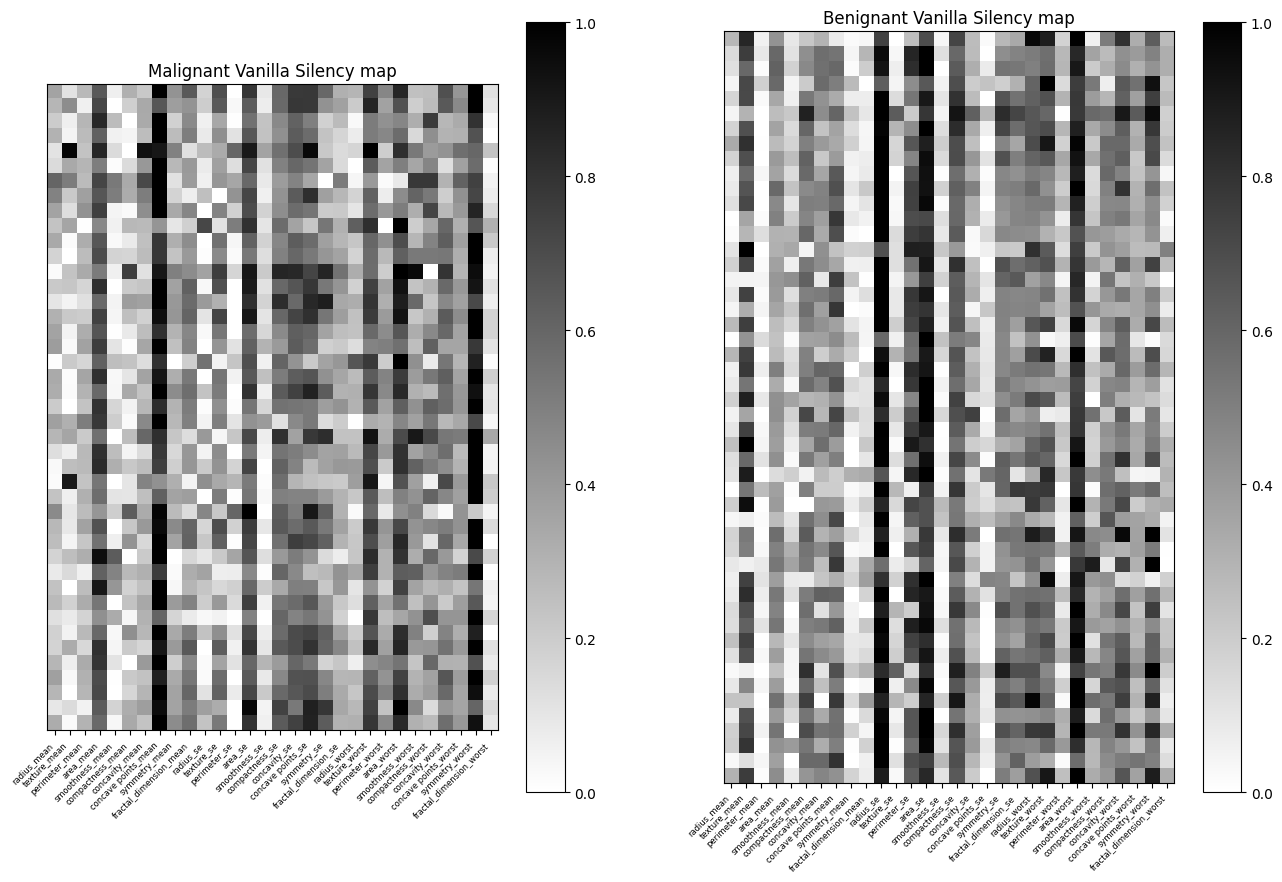

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

#  Malignant Silency map
im1 = axs[0].imshow(malignant.iloc[:, :], cmap='binary', vmin=malignant.iloc[0, :].min(), vmax=malignant.iloc[0, :].max())
axs[0].set_title('Malignant Vanilla Silency map')
axs[0].set_xticks(range(len(malignant.columns)))
axs[0].set_xticklabels(malignant.columns, rotation=45, ha='right', fontsize=6)
axs[0].set_yticks([])
axs[0].set_yticklabels([])
plt.colorbar(im1, ax=axs[0])

#  Benignant Silency map
# Notice that here w edisplay just the first 55 rows to have a better visualization in the heat map, the final pattern with all the observation do not change!
im2 = axs[1].imshow(benignant.iloc[:50, :], cmap='binary', vmin=benignant.iloc[0, :].min(), vmax=benignant.iloc[0, :].max())
axs[1].set_title('Benignant Vanilla Silency map')
axs[1].set_xticks(range(len(malignant.columns)))
axs[1].set_xticklabels(malignant.columns, rotation=45, ha='right', fontsize=6)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
plt.colorbar(im2, ax=axs[1])

plt.show()


- MALIGNANT:\
With a visualisation of the type above, it is very clear and obvious that depending on the class to which it belongs, there are data attributes that have different 'weights'. In the case of a malignant tumour, the "concavity mean" turns out to be a very relevant feature, which in fact was the one with a surplus over the calculated difference in the previous largest section. "Area worst" and "simmetry wrost" also prove to be important by having a real black line drawn on the map in their correspondence;
- BENIGNANT:\
"radius se" ,"perimeter mean","area worst" and "area se" appear to be the most relevant for the detection of benignant tumors, that are basically the three black columns that we can distinguish in the right silency map;

**Exercise 4.2**: write a function to compute the global saliency and try to explain the results.

In [ ]:
# TODO: Write the required function.
def Global_Silency(Jacobian):
  jacobian = tf.convert_to_tensor(Jacobian.values, dtype=tf.float32)
  mean_values = tf.reduce_mean(jacobian, axis=0)
  # Reshape the result to have a single row and the same number of columns
  global_silency = tf.reshape(mean_values, shape=(1, -1))
  return(global_silency)

benignant_global = Global_Silency(benignant)

global_silency_benignant= show_grad(benignant_global,X_test)
global_silency_benignant.index= ['Benignant Tumor']
global_silency_benignant.style.background_gradient(cmap='binary', vmin= comparison_data.iloc[0, :].min(), vmax= comparison_data.iloc[0, :].max())

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
Benignant Tumor,0.133989,0.579541,0.043385,0.410473,0.137496,0.494162,0.384759,0.525100,0.100695,0.122552,0.925255,0.123364,0.616990,0.881478,0.096495,0.660793,0.309562,0.100091,0.516912,0.463564,0.578385,0.587708,0.186915,0.864082,0.286897,0.436732,0.555316,0.321952,0.558545,0.192105


In [ ]:
malignant_global = Global_Silency(malignant)

global_silency_malignant= show_grad(malignant_global,X_test)
global_silency_malignant.index= ['Malignant Tumor']
global_silency_malignant.style.background_gradient(cmap='binary', vmin= comparison_data.iloc[0, :].min(), vmax= comparison_data.iloc[0, :].max())

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
Malignant Tumor,0.244663,0.180505,0.258998,0.675734,0.140035,0.204067,0.323885,0.888237,0.284626,0.417104,0.175769,0.417663,0.132680,0.692222,0.124817,0.545723,0.590904,0.612197,0.428346,0.309772,0.220384,0.677234,0.321728,0.698872,0.406970,0.412625,0.471234,0.376907,0.852274,0.109436


The results of the *Global Silency* highlights the collected results in the "How much noise do we need?" section, where one feature had a bigger difference among gradients. For example in the malignant case "Concave points mean" is one of the features with highest magnitude, indicating that it is one of the features on which the output of our model depends most, given the $x^i$ data point.\
Furthermore also "simmetry_worst" results to be important, infact in malignant silency map it was one of the very distinguishable black column.

- In coclusion we can state that Global Silency is a good approximation to the importance of features in a model respect to the output, but by dividing the silency map with respect to the $c$ class we are able to understand which features the model emphasises for one or the other class.


**Exercise 4.3**: note that a linear model $f(x) = w^\top x + b$ is an example of an *intrinsically* interpretable  model, since the weights $w$ can be checked to analyze the global saliency of each feature (see [3]).

In [ ]:
# TODO: Compare the results you obtained before with a simpler linear model.

linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation=None) ] )    # A very simple forward pass w^Tx+b that gives us
                                                     # weights for each feature;
# Compile the model
linear_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),

              metrics=['accuracy'])

batch_size=32
linear_epochs = 100
linear_model.fit(data_train.batch(batch_size), epochs=linear_epochs, verbose=False)
# Evaluate linear model on the test set
test_loss, test_accuracy = linear_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {round(test_accuracy,2)}")
linear_model.summary() #This will return 31 parameters, if we want not take into account the bias term we can simply add 'use_bias=False' in the model architecture;

4/4 [==============================] - 0s 4ms/step - loss: 0.5975 - accuracy: 0.9386
Test Accuracy: 0.94
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1)                 31        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The point of this comparison is basically to investigate how features are weighted in a linear model, which is extremely explainable (having a specific weight for each feature) compared to a neural network that has weights for each hidden layer of neurons, thus being less interpretable.\
The point here is to check in the linear model row the magnitudes of weights which were found to be more informative. We will take the conclusions drawn from the Global Silency map as a reference point and compare them with the linear, vanilla method and SmoothGrad with 20% noise, which was found to be the most consistent.

In [ ]:
w_linear = np.abs(linear_model.layers[0].get_weights())
# Extracting weights;
weights = w_linear[0].flatten()
linear_df, linear_df.columns = pd.DataFrame({'Linear Weights': weights}).transpose(),  X_test.columns
#Standardize with MinMax scaler by row the linear weights
# Define a min-max normalization function
def min_max_normalize(row):
    min_val = row.min()
    max_val = row.max()
    return (row - min_val) / (max_val - min_val)

# Apply the min-max normalization function to each row in order to compare the values with the other methods developed above;
linear_df = linear_df.apply(min_max_normalize, axis=1)

#display weighting magnitudes with a linear model;
linear_df.style.background_gradient(cmap='binary', vmin= linear_df.iloc[0, :].min(), vmax= linear_df.iloc[0, :].max())

<ipython-input-74-2320fd4096c8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_linear = np.abs(linear_model.layers[0].get_weights())


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
Linear Weights,0.275840,0.331173,0.052730,0.124761,0.318774,0.527730,0.185051,0.682105,0.567134,0.024830,0.535931,0.244630,0.661999,0.605564,0.634346,0.624369,0.109468,0.518604,0.533406,0.023749,0.407112,0.987858,0.805202,0.483062,0.308036,0.559819,1.000000,0.278292,0.185197,0.000000


In [ ]:
linear_comparison = pd.concat([linear_df, best_smooth])
linear_comparison

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
Linear Weights,0.559855,0.426444,0.103244,0.092455,0.119802,0.016890,0.160329,0.166161,0.190895,0.120657,...,0.068110,0.111902,0.573029,0.012432,0.301468,0.151975,0.330567,0.096608,0.285933,0.000435
vanilla_silency,0.282379,0.848024,0.056806,0.420431,0.095877,0.220322,0.298151,0.078237,0.020574,0.033003,...,0.961957,0.880362,0.170227,1.000000,0.061956,0.512762,0.804392,0.322699,0.635255,0.268682
SmoothG Noise=20%,0.276340,0.419424,0.013215,0.398008,0.046508,0.334323,0.186203,0.268169,0.043435,0.193069,...,0.644293,0.743303,0.000000,1.000000,0.156783,0.510444,0.547996,0.176046,0.499078,0.198705


As you can clearly see, a linear model is convenient because it can be easily interpreted but it is inconsistent wrt *Global Silency map* results. Taking into account the class $c$ of our test data point (a binignant one) we expect as the most relevant feature the following:

In [ ]:
print(f'Notice that the first observation is',y_test.iloc[0],'so a benignant example!')
global_silency_benignant.loc[:,global_silency_benignant.iloc[0] >0.65] #we use as benchmark the higher scores from benignant Global silency map

Notice that the first observation is 0 so a benignant example!


,radius_se,area_se,compactness_se,area_worst
Benignant Tumor,0.925255,0.881478,0.660793,0.864082


What we can state is that the linear model is much more *instable* in the sense that with different running it figure out every time differnt feature to highlight, in this case for example they are "concave_points_worst" and "texture_worst" (that are not present in the above table) but this instability does not allow us to understand through these weights what the pattern of importance of each feature is in relation to the output. \
So it is true that a linear one is more and easily interpretable but it does not allow us to recontruct an 'importance' pattern for the feature due to a strong inconsistence.

### Optional exercises and parting words

> ⚠ Explainability is a complex topic, with multiple issues arising from the over-abundance of techniques, their instability, etc. While an interesting research topic to pursue, never use blindly these techniques in high-stake applications!

These exercises were just a brief and short introduction to the topic of explainability. Below you can find some additional exercises to tackle if you are interested. Remember that these are not part of your grade, but I am happy to provide feedback if they are of interest to you.

1. There are dozens of possible variations on feature attribution methods, which may or may not provide better results (see [4] for a benchmarking and this nice [Distill blog post](https://distill.pub/2020/attribution-baselines/)). **[Integrated Gradients](https://arxiv.org/abs/1703.01365)** are an interesting example, where the saliency is integrated over a path ranging from an empty input to the true input. Try implementing integrated gradients.
2. **Data attribution** methods are a different class of explanation methods, which try to predict what points in the dataset where most influential to a given prediction (e.g., a picture of a cat will be especially influential on similar pictures). One example of such methods is TracIn [5], which stores checkpoints of the model during training and evaluates the correlation of the gradients. Try to implement TracIn or any other metric of data influence.
3. A recent line of research tries to use large language models (e.g., ChatGPT) to explain other models (e.g., see [Language models can explain neurons in language models](https://openai.com/research/language-models-can-explain-neurons-in-language-models)). If you have access to an LLM, you can try it! Take a specific neuron in the model, and collect the activation for multiple examples. Provide these activations to the LLM, and prompt it to provide a human-understandable explanation. What is the result?

### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 17/11/2023 23:59** on the Google Classrom page.

### Bibliography

[1] Simonyan, K., Vedaldi, A. and Zisserman, A., 2013. [Deep inside convolutional networks: Visualising image classification models and saliency maps](https://arxiv.org/abs/1312.6034). arXiv preprint arXiv:1312.6034.

[2] Smilkov, D., Thorat, N., Kim, B., Viégas, F. and Wattenberg, M., 2017. [SmoothGrad: removing noise by adding noise](https://arxiv.org/abs/1706.03825). arXiv preprint arXiv:1706.03825.

[3] Rudin, C., 2019. [Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead](https://www.nature.com/articles/s42256-019-0048-x). Nature Machine Intelligence, 1(5), pp. 206-215.

[4] Nguyen, G., Kim, D. and Nguyen, A., 2021. [The effectiveness of feature attribution methods and its correlation with automatic evaluation scores](https://proceedings.neurips.cc/paper/2021/hash/de043a5e421240eb846da8effe472ff1-Abstract.html). Advances in Neural Information Processing Systems, 34, pp.26422-26436.

[5] Pruthi, G., Liu, F., Kale, S. and Sundararajan, M., 2020. [Estimating training data influence by tracing gradient descent](https://proceedings.neurips.cc/paper/2020/hash/e6385d39ec9394f2f3a354d9d2b88eec-Abstract.html). Advances in Neural Information Processing Systems, 33, pp. 19920-19930.